In [93]:
import pandas as pd
import duckdb
import hvplot.pandas
from deltalake import DeltaTable

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
pio.renderers.default = "nteract"

import matplotlib.colors


In [94]:
df = pd.read_parquet('./data/ridership/passengers_daily.parquet')
df_sankey = duckdb.sql("""
            SELECT station_name_origin, station_name_destination, sum(passengers) as passengers
           FROM df
           GROUP BY 1,2
           """).df()

df_sankey_top10 = df_sankey.sort_values('passengers', ascending=False)[:20]
df_sankey_top10.head()

,station_name_origin,station_name_destination,passengers
11573,Tun Razak Exchange (origin),Bukit Bintang (destination),191976.0
8382,KLCC (origin),Ampang Park (destination),147679.0
7252,Bukit Bintang (origin),Tun Razak Exchange (destination),147415.0
2372,Ampang Park (origin),KLCC (destination),125545.0
12069,KL Sentral (origin),KLCC (destination),121270.0


In [95]:
df_sankey_top10 = df_sankey.sort_values('passengers', ascending=False)[:20]

def prepare_sankey(dataframe:pd.DataFrame, source:pd.Series, target:pd.Series, opacity:float = 0.5, color_tone = px.colors.qualitative.G10):
    """
    This function will convert a dataframe into readable format for Plotly Sankey chart
    Sample table input:

    |  source  |  target  | value  |  
    |------------------------------|
    |    a1     |    b1     |   1  |
    |------------------------------|
    |    a2     |    b1     |   3  |
    |------------------------------|
    
    color_tone:
        # https://plotly.com/python/discrete-color/
        fig = px.colors.qualitative.swatches()
        fig.show()

    """
    source = source.name
    target = target.name

    data = dataframe.copy()

    unique_source_target = list(pd.unique(data[[source, target]].values.ravel('K')))

    # Define a list of hex color codes for nodes
    node_colors = color_tone

     # Create var to hold node/label and link colors
    label_colors, data["link_colors"] = [], str(0)

    # Convert list of colors to RGB format to override default gray LINK colors
    colors = [matplotlib.colors.to_rgb(i) for i in node_colors]  

    # Loop through all the labels to specify color and to use label indices
    c, max_colors = 0, len(colors)  # To loop through the colors array
    for l in range(len(unique_source_target)):
        label_colors.append(colors[c])
        link_color = colors[c] + (opacity,)  # Make link more transparent than the node
        data.loc[data[target] == unique_source_target[l], "link_colors"] = "rgba" + str(link_color)
        # data.loc[data[source] == unique_source_target[l], "link_colors"] = "rgba" + str(link_color) # uncomment this line if want the LINK color to follow source node color
        if c == max_colors - 1:
            c = 0
        else:
            c += 1

    # Convert colors into RGB string format for Plotly
    label_colors = ["rgb" + str(i) for i in label_colors]

    #for assigning unique number to each source and target
    mapping_dict = {k: v for v, k in enumerate(unique_source_target)}

    #mapping of full data
    data[source] = data[source].map(mapping_dict)
    data[target] = data[target].map(mapping_dict)

    links_dict = data.to_dict(orient='list')

    return links_dict, unique_source_target, label_colors


links, unique_source_target, label_colors = prepare_sankey(dataframe=df_sankey_top10,
                       source=df_sankey_top10['station_name_origin'],
                       target=df_sankey_top10['station_name_destination']
                       )

In [96]:
#Sankey Diagram Code 
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.7),
      label = unique_source_target,
      color = label_colors
      
    ),
    link = dict(
      arrowlen=35,
      source = links["station_name_origin"],
      target = links["station_name_destination"],
      value = links["passengers"]
      ,color = links["link_colors"]
  
  ))])

fig.update_layout(title_text="Train Passengers To-From Stations",
                  autosize=False,
                  width=750,
                  height=1000,)

# How to color the links: https://plotly.com/python/sankey-diagram/ 
fig.show()

## Using HoloViz

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
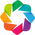

In [97]:
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

In [98]:
def fmt(tick):
    if tick < 1e3:
        unit = ''
        num =  round(tick,2)
    elif tick < 1e6:
        unit = 'k'
        num =  round(tick/1e3,2)
    else:
        unit = 'm'
        num =  round(tick/1e6,2)
    return f'{num}{unit}'



edges = df_sankey_top10
edges.columns = ['source', 'target', 'value']
sankey = hv.Sankey(data=edges, kdims=['source', 'target'], 
                   vdims=[hv.Dimension("value", value_format=fmt)], 
                   label='Rail Diagram')

# Options: https://holoviews.org/reference_manual/holoviews.plotting.bokeh.html
sankey.opts(label_position='left', edge_color='target', node_color='index', cmap='tab20', width = 1200, height= 1000, node_width = 30, fontsize= 14)
# sankey.opts(fontsize={'title': 35, 'label_text_font_size': 35})

:Sankey   [source,target]   (value)

In [99]:
hv.renderer('bokeh').save(sankey, 'rrr', fmt='html')
# kena save as html dulu, open in browser then download the pic

# ['html', 'auto', 'png', 'widgets', 'scrubber', 'gif', 'auto', None]